Con este programa generamos un dataframe con datos de imagenes

In [1]:
import os

home = os.path.expanduser("~")

db_name=  'colab_main_dataset_25' #'test_new_creators_4'
#input_dir = os.path.join(home, 'video_resources', 'image_datasets')
output_dir = os.path.join(home, 'video_resources', 'sql_database')
#output_dir = os.path.join(home, 'drive', '.shared','LR_face_video')
#database_names=['enfsi','lfw','forenface'] # 'lfw', 'scface',  'enfsi', 'enfsi2015', 'xqlfw', 'utkface','chokepoint','forenface'
#detector_names=['mtcnn'] # 'dlib', 'mtcnn', 'mtcnn_serfiq'
#embedding_model_names=["QMagFace"] # , "Dlib", "ArcFace",
#attributes_to_update=[]  # 'gender', 'age', 'emotion', 'race'
#quality_model_names = ['ser_fiq', 'tface'] # 'confusion_score', 'ser_fiq',

In [2]:
from sql_face.alchemy import get_session
session = get_session(output_dir, db_name)



2023-07-11 22:14:28.249880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sql_face.tables import  QualityImage, FaceImage, CroppedImage, Image, QualityModel, QualityGroup,Detector, EmbeddingModel,EnfsiImage,EnfsiVideoFrame

# embedding Models QMagFace y QMagFace_SR
## Calibración:
- XQLFW
- UTKface
- SCFace
- ForenFace
- ChokePoint
## Test
- Enfsi (2015)


In [4]:
models = ['QMagFace','QMagFace_SR']
calibration = ['XQLFW','UTKface','SCFace','ForenFace','ChokePoint']
test = []

In [5]:

results1 = session.query(Image,Detector.name,EmbeddingModel.name,QualityModel.name,QualityImage.quality_group,QualityImage.quality) \
                        .select_from(Image).filter(Image.source.in_(calibration) ) \
                        .join(CroppedImage).join(Detector).filter(CroppedImage.face_detected == True) \
                        .join(FaceImage).join(EmbeddingModel).filter(EmbeddingModel.name.in_(models)) \
                        .join(QualityImage).join(QualityModel) \
                        .filter(QualityImage.quality != None) \
                        .all() 
#.filter(EnfsiVideoFrame.yaw !=None)
#

In [6]:

results2 = session.query(Image,Detector.name,EmbeddingModel.name,QualityModel.name,QualityImage.quality_group,QualityImage.quality) \
                        .select_from(Image).filter(Image.type == 'enfsiImage',Image.path.like('%2015%')) \
                        .join(CroppedImage).join(Detector).filter(CroppedImage.face_detected == True) \
                        .join(FaceImage).join(EmbeddingModel).filter(EmbeddingModel.name.in_(models)) \
                        .join(QualityImage).join(QualityModel) \
                        .filter(QualityImage.quality != None) \
                        .all() 
#.filter(EnfsiVideoFrame.yaw !=None)

In [7]:
im_cols = ['identity', 'pitch', 'angle_pitch', 'yaw', 'angle_yaw', 'roll','angle_roll',
           'source', 'gender', 'headgear',  'age','age_number',
            'glasses', 'type',  'beard', 'emotion', 'other_occlusions',
            'race',  'image_id']
fixed_cols = ['Detector','E_Model','Q_Model','Q_group','Quality']

df1 = pd.DataFrame([ [getattr(r[0],attr)   for attr in im_cols]  + list(r[1:6])
                   for r in results1],
                   columns=im_cols + fixed_cols )
df2 = pd.DataFrame([ [getattr(r[0],attr)   for attr in im_cols]  + list(r[1:6])
                   for r in results2],
                   columns=im_cols + fixed_cols )

df = df1.append(df2)
df.reset_index(inplace=True)

df.to_pickle(os.path.join(output_dir,'df_colab_25.pkl'))


In [8]:
df

,index,identity,pitch,angle_pitch,yaw,angle_yaw,roll,angle_roll,source,gender,...,beard,emotion,other_occlusions,race,image_id,Detector,E_Model,Q_Model,Q_group,Quality
0,0,060,Pitch.HALF_UP,NaN,Yaw.FRONTAL,NaN,Roll.FRONTAL,NaN,SCFace,Gender.MALE,...,False,Emotion.NEUTRAL,None,Race.WHITE,391,mtcnn,QMagFace,ser_fiq,QualityGroup.HIGH,0.692671
1,1,030,Pitch.HALF_DOWN,NaN,Yaw.FRONTAL,NaN,Roll.FRONTAL,NaN,SCFace,Gender.MALE,...,False,Emotion.NEUTRAL,None,Race.WHITE,392,mtcnn,QMagFace,ser_fiq,QualityGroup.VERY_LOW,0.003943
2,2,047,Pitch.DOWN,NaN,Yaw.FRONTAL,NaN,Roll.FRONTAL,NaN,SCFace,Gender.MALE,...,False,Emotion.NEUTRAL,None,Race.WHITE,393,mtcnn,QMagFace,ser_fiq,QualityGroup.HIGH,0.746437
3,3,014,Pitch.FRONTAL,NaN,Yaw.PROFILE,NaN,None,NaN,SCFace,Gender.FEMALE,...,False,Emotion.NEUTRAL,None,Race.WHITE,394,mtcnn,QMagFace,ser_fiq,QualityGroup.VERY_LOW,0.000380
4,4,035,Pitch.FRONTAL,NaN,Yaw.FRONTAL,NaN,Roll.HALF_LEANING,NaN,SCFace,Gender.MALE,...,True,Emotion.NEUTRAL,None,Race.WHITE,395,mtcnn,QMagFace,ser_fiq,QualityGroup.VERY_HIGH,0.861327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644964,1105,2015-7,Pitch.FRONTAL,0.567765,Yaw.PROFILE,-55.055234,Roll.FRONTAL,-3.960244,ENFSI,Gender.MALE,...,None,Emotion.FEAR,None,Race.WHITE,6019,mtcnn_serfiq,QMagFace_SR,ser_fiq,QualityGroup.LOW,0.189554
644965,1106,2015-1,Pitch.HALF_UP,-13.379150,Yaw.FRONTAL,-7.007500,Roll.FRONTAL,1.321452,ENFSI,Gender.FEMALE,...,None,Emotion.NEUTRAL,None,Race.WHITE,4676,mtcnn_serfiq,QMagFace_SR,ser_fiq,QualityGroup.HIGH,0.734290
644966,1107,2015-1,Pitch.FRONTAL,-5.347922,Yaw.FRONTAL,-3.339354,Roll.FRONTAL,-0.575616,ENFSI,Gender.FEMALE,...,None,Emotion.ANGRY,None,Race.WHITE,4684,mtcnn_serfiq,QMagFace_SR,ser_fiq,QualityGroup.VERY_HIGH,0.794687
644967,1108,2015-14,Pitch.HALF_DOWN,2.943040,Yaw.PROFILE,44.091928,Roll.HALF_LEANING,7.737190,ENFSI,Gender.MALE,...,None,Emotion.HAPPY,None,Race.WHITE,7712,mtcnn_serfiq,QMagFace_SR,ser_fiq,QualityGroup.HIGH,0.728360


In [10]:
df.groupby(['source','Detector','E_Model']).size()

source      Detector      E_Model    
ChokePoint  mediapipe     QMagFace        31446
            mtcnn         QMagFace       144044
            mtcnn_serfiq  QMagFace       143130
                          QMagFace_SR     71565
ENFSI       mediapipe     QMagFace          308
            mtcnn         QMagFace          328
            mtcnn_serfiq  QMagFace          316
                          QMagFace_SR       158
ForenFace   mediapipe     QMagFace         4398
            mtcnn         QMagFace         4742
            mtcnn_serfiq  QMagFace         4684
SCFace      mediapipe     QMagFace         8262
            mtcnn         QMagFace         7764
            mtcnn_serfiq  QMagFace         7682
UTKface     mediapipe     QMagFace        45314
            mtcnn         QMagFace        48092
            mtcnn_serfiq  QMagFace        47910
XQLFW       mediapipe     QMagFace        22228
            mtcnn         QMagFace        26318
            mtcnn_serfiq  QMagFace        26280
dt

<AxesSubplot: >

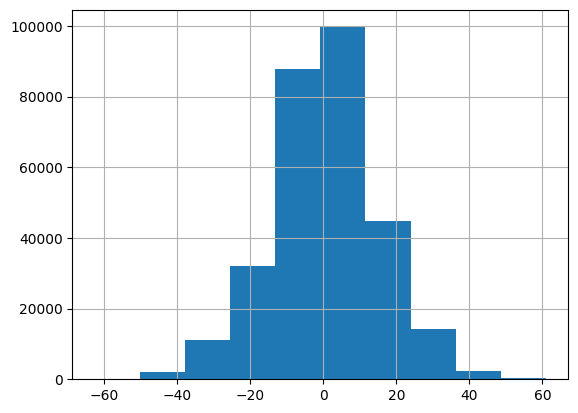

In [11]:
df.angle_yaw.hist()

In [12]:
df2 = df.loc[df.source == "UTKface"]

In [13]:
df2

,index,identity,pitch,angle_pitch,yaw,angle_yaw,roll,angle_roll,source,gender,...,beard,emotion,other_occlusions,race,image_id,Detector,E_Model,Q_Model,Q_group,Quality
7723,7723,20170105183531601,Pitch.HALF_DOWN,4.906499,Yaw.FRONTAL,-1.561819,Roll.FRONTAL,2.991453,UTKface,Gender.FEMALE,...,None,Emotion.HAPPY,None,Race.LATINO,21827,mtcnn,QMagFace,ser_fiq,QualityGroup.HIGH,0.684553
7724,7724,20170117183513718,Pitch.FRONTAL,-5.383751,Yaw.PROFILE,27.349625,Roll.HALF_LEANING,-7.731156,UTKface,Gender.MALE,...,None,Emotion.NEUTRAL,None,Race.BLACK,21828,mtcnn,QMagFace,ser_fiq,QualityGroup.LOW,0.170220
7725,7725,20170104205235021,Pitch.DOWN,17.997937,Yaw.HALF_TURNED,12.251596,Roll.FRONTAL,6.275913,UTKface,Gender.FEMALE,...,None,Emotion.ANGRY,None,Race.WHITE,21829,mtcnn,QMagFace,ser_fiq,QualityGroup.MEDIUM,0.578468
7726,7726,20170104185725302,Pitch.UP,-19.648167,Yaw.PROFILE,-21.811530,Roll.FRONTAL,2.958774,UTKface,Gender.MALE,...,None,Emotion.HAPPY,None,Race.WHITE,21830,mtcnn,QMagFace,ser_fiq,QualityGroup.LOW,0.039000
7727,7727,20170117183000621,Pitch.HALF_DOWN,3.418834,Yaw.FRONTAL,4.668859,Roll.FRONTAL,0.827290,UTKface,Gender.MALE,...,None,Emotion.NEUTRAL,None,Race.WHITE,21831,mtcnn,QMagFace,ser_fiq,QualityGroup.MEDIUM,0.576240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239845,239845,20170104021011429,Pitch.DOWN,26.685466,Yaw.FRONTAL,9.823347,Roll.FRONTAL,-3.616617,UTKface,Gender.FEMALE,...,None,Emotion.HAPPY,None,Race.ASIAN,35680,mtcnn,QMagFace,ser_fiq,QualityGroup.HIGH,0.690494
239846,239846,20170113175408636,Pitch.FRONTAL,-4.737055,Yaw.PROFILE,-30.475487,Roll.FRONTAL,-2.409059,UTKface,Gender.MALE,...,None,Emotion.NEUTRAL,None,Race.BLACK,35681,mtcnn,QMagFace,ser_fiq,QualityGroup.VERY_LOW,0.004411
239847,239847,20170116222058188,Pitch.HALF_DOWN,1.463982,Yaw.PROFILE,-21.413508,Roll.FRONTAL,-1.744835,UTKface,Gender.MALE,...,None,Emotion.SAD,None,Race.BLACK,35682,mtcnn,QMagFace,ser_fiq,QualityGroup.MEDIUM,0.521457
239848,239848,20170113012239224,Pitch.FRONTAL,-6.145098,Yaw.FRONTAL,-8.771137,Roll.HORIZONTAL,42.560143,UTKface,Gender.FEMALE,...,None,Emotion.NEUTRAL,None,Race.BLACK,35683,mtcnn,QMagFace,ser_fiq,QualityGroup.LOW,0.282057


In [14]:
df[['source','Q_Model','E_Model','Detector','yaw']].groupby(['source','Q_Model','E_Model','Detector']).size()

source      Q_Model  E_Model      Detector    
ChokePoint  ser_fiq  QMagFace     mediapipe       15723
                                  mtcnn           72022
                                  mtcnn_serfiq    71565
                     QMagFace_SR  mtcnn_serfiq    71565
            tface    QMagFace     mediapipe       15723
                                  mtcnn           72022
                                  mtcnn_serfiq    71565
ENFSI       ser_fiq  QMagFace     mediapipe         154
                                  mtcnn             164
                                  mtcnn_serfiq      158
                     QMagFace_SR  mtcnn_serfiq      158
            tface    QMagFace     mediapipe         154
                                  mtcnn             164
                                  mtcnn_serfiq      158
ForenFace   ser_fiq  QMagFace     mediapipe        2199
                                  mtcnn            2371
                                  mtcnn_serfiq     2342
 

In [15]:
df.source.value_counts()

ChokePoint    390185
UTKface       141316
XQLFW          74826
SCFace         23708
ForenFace      13824
ENFSI           1110
Name: source, dtype: int64